In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd, numpy as np, os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML

font = {'size'   : 18}
matplotlib.rc('font', **font)

def plotHorizontalBars(series, xlabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.barh(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='x')
    plt.yticks(xpos, series.index)
    plt.xlabel(xlabel)
    plt.title(title)

def plotVerticalBars(series, ylabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.bar(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='y')
    plt.xticks(xpos, series.index)
    plt.ylabel(ylabel)
    plt.title(title)

In [3]:
import ssl, re
ssl._create_default_https_context = ssl._create_unverified_context
pd.__version__

'0.24.2'

In [4]:
# on Github, open CSV file and click on 'Raw'. Copy URL

filename = 'time_series_19-covid-Confirmed.csv'
data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+filename
ts_df = pd.read_csv(data_url)
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Diamond Princess', x) is not None)]
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Grand Princess', x) is not None)]
ts_df = ts_df.sort_values(['Country/Region', 'Province/State'])
print(ts_df['Country/Region'].unique())
display(ts_df)

['Afghanistan' 'Algeria' 'Andorra' 'Argentina' 'Armenia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahrain' 'Belarus' 'Belgium' 'Bhutan'
 'Bosnia and Herzegovina' 'Brazil' 'Cambodia' 'Cameroon' 'Canada' 'Chile'
 'Colombia' 'Costa Rica' 'Croatia' 'Czech Republic' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia' 'Faroe Islands'
 'Finland' 'France' 'French Guiana' 'Georgia' 'Germany' 'Gibraltar'
 'Greece' 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan' 'Jordan' 'Kuwait' 'Latvia'
 'Lebanon' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Macau'
 'Mainland China' 'Malaysia' 'Malta' 'Martinique' 'Mexico' 'Monaco'
 'Morocco' 'Nepal' 'Netherlands' 'New Zealand' 'Nigeria' 'North Macedonia'
 'Norway' 'Oman' 'Pakistan' 'Palestine' 'Peru' 'Philippines' 'Poland'
 'Portugal' 'Qatar' 'Romania' 'Russia' 'Saint Barthelemy' 'San Marino'
 'Saudi Arabia' 'Senegal' 'Serbia' 'Singapore' 'Slovakia' 'Slovenia'
 'South Africa' 'South Korea' 'Spain' 'Sri Lan

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
82,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
85,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1,1,1,1,3,5,12,12,17,17
121,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
136,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,2,8
117,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
47,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,4,4,4,6,6,13,22,22,26,28
147,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
49,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,5,5,9,9,9,11,11,13,13,13
63,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,2,2,3,3,3,3,5,5,7,7
122,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

lin_df = ts_df.drop(['Lat', 'Long', 'Province/State'], axis=1)
lin_df = lin_df.groupby('Country/Region').sum().transpose()
lin_df['date_count'] = [i for i in range(lin_df.shape[0])]
display(lin_df.tail(7))

Country/Region,Afghanistan,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,Belgium,Bhutan,Bosnia and Herzegovina,Brazil,Cambodia,Cameroon,Canada,Chile,Colombia,Costa Rica,Croatia,Czech Republic,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Faroe Islands,Finland,France,French Guiana,Georgia,Germany,Gibraltar,Greece,Hong Kong,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Japan,Jordan,Kuwait,Latvia,Lebanon,Liechtenstein,Lithuania,Luxembourg,Macau,Mainland China,Malaysia,Malta,Martinique,Mexico,Monaco,Morocco,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Palestine,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Saint Barthelemy,San Marino,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Togo,Tunisia,UK,US,Ukraine,United Arab Emirates,Vatican City,Vietnam,date_count
3/1/20,1,1,0,0,1,27,14,3,47,1,2,0,0,2,1,0,24,0,0,0,7,3,4,1,6,2,1,0,6,130,0,3,130,0,7,96,0,3,3,0,978,19,1,10,1694,256,0,45,0,10,0,1,1,10,79826,29,0,0,5,1,0,1,10,1,1,1,19,6,4,0,0,3,0,0,3,3,2,0,1,0,0,0,106,0,0,0,3736,84,1,14,27,40,42,0,0,36,32,0,21,0,16,39
3/2/20,1,3,1,0,1,30,18,3,49,1,8,0,0,2,1,0,27,0,0,0,7,3,4,1,6,2,1,0,6,191,0,3,159,0,7,100,0,6,5,2,1501,26,1,10,2036,274,0,56,1,13,0,1,1,10,80026,29,0,0,5,1,1,1,18,1,1,1,25,6,4,0,0,3,0,2,3,3,3,0,8,1,1,0,108,0,0,0,4335,120,1,15,42,41,43,0,0,40,56,0,21,0,16,40
3/3/20,1,5,1,1,1,39,21,3,49,1,13,0,0,2,1,0,30,1,0,0,9,5,6,1,7,2,2,0,6,204,0,3,196,0,7,100,0,11,5,2,2336,32,2,12,2502,293,1,56,1,13,0,1,1,10,80151,36,0,0,5,1,1,1,24,1,1,1,32,12,5,0,0,3,0,2,7,3,3,0,10,1,2,0,110,0,0,0,5186,165,1,21,56,42,43,0,0,51,76,1,27,0,16,41
3/4/20,1,12,1,1,1,52,29,3,52,6,23,0,0,4,1,0,33,1,0,0,10,8,10,1,10,2,2,1,6,285,0,3,262,1,9,105,2,26,28,2,2922,35,6,15,3089,331,1,56,1,13,1,1,1,10,80271,50,0,0,5,1,1,1,38,3,1,1,56,15,5,0,0,3,1,5,8,4,3,3,16,1,4,0,110,0,0,0,5621,222,1,35,90,42,43,0,1,85,107,1,27,0,16,42
3/5/20,1,12,1,1,1,55,41,6,55,6,50,0,2,4,1,0,37,4,0,0,10,12,10,1,13,3,3,1,12,377,0,4,482,1,31,105,2,34,30,2,3513,35,6,16,3858,360,1,58,1,16,1,1,1,10,80422,50,0,0,5,1,2,1,82,3,1,1,87,16,5,4,0,3,1,8,8,6,4,3,21,5,4,0,117,0,2,1,6088,259,1,94,114,44,47,0,1,115,175,1,29,0,16,43
3/6/20,1,17,1,2,1,60,55,6,60,6,109,1,2,13,1,1,49,4,1,1,11,18,23,2,13,15,10,1,15,653,0,4,670,1,45,107,2,43,31,4,4747,40,18,21,4636,420,1,58,1,22,1,1,2,10,80573,83,0,0,6,1,2,1,128,4,1,3,108,16,6,16,1,5,5,13,8,9,13,3,21,5,4,1,130,1,7,1,6593,400,1,101,214,45,48,1,1,163,232,1,29,1,16,44
3/7/20,1,17,1,8,1,63,79,9,85,6,169,1,3,13,1,1,54,4,1,1,12,19,23,2,13,15,10,1,15,949,5,4,799,1,46,108,4,50,34,4,5823,54,18,21,5883,461,1,61,1,22,1,1,2,10,80652,93,3,2,6,1,2,1,188,5,1,3,147,16,6,22,1,6,5,20,8,9,13,3,23,5,4,1,138,1,7,1,7041,500,1,161,268,45,50,1,1,206,351,1,45,1,18,45


In [6]:
log_df = lin_df.copy()
log_df[log_df == 0] = 1e-5
log_df = np.log(log_df)
log_df[log_df < 0.1] = 0.0
log_df.date_count = lin_df.date_count
display(log_df.head(4))

Country/Region,Afghanistan,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,Belgium,Bhutan,Bosnia and Herzegovina,Brazil,Cambodia,Cameroon,Canada,Chile,Colombia,Costa Rica,Croatia,Czech Republic,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Faroe Islands,Finland,France,French Guiana,Georgia,Germany,Gibraltar,Greece,Hong Kong,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Japan,Jordan,Kuwait,Latvia,Lebanon,Liechtenstein,Lithuania,Luxembourg,Macau,Mainland China,Malaysia,Malta,Martinique,Mexico,Monaco,Morocco,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Palestine,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Saint Barthelemy,San Marino,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Togo,Tunisia,UK,US,Ukraine,United Arab Emirates,Vatican City,Vietnam,date_count
1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.304449,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,6.459904,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.098612,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.693147,1
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,6.820016,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,1.098612,1.609438,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,2
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,7.243513,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,1.098612,1.945910,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,3


Country/Region,date_count,US,Italy,South Korea,Germany,France,Iran
3/1/20,39,32,1694,3736,130,130,978
3/2/20,40,56,2036,4335,159,191,1501
3/3/20,41,76,2502,5186,196,204,2336
3/4/20,42,107,3089,5621,262,285,2922
3/5/20,43,175,3858,6088,482,377,3513
3/6/20,44,232,4636,6593,670,653,4747
3/7/20,45,351,5883,7041,799,949,5823


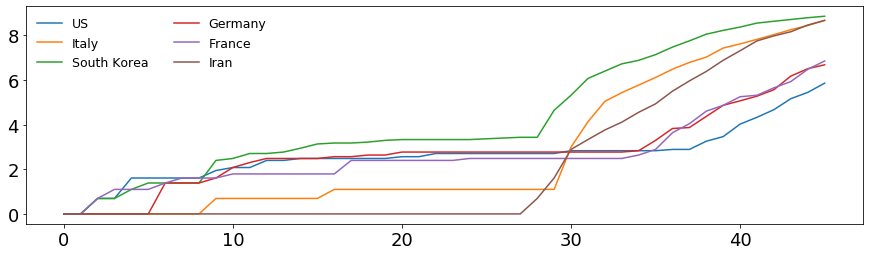

In [7]:
countries = ['Mainland China', 'US', 'Italy', 'South Korea', 'Germany']
countries = ['US', 'Italy', 'South Korea', 'Germany', 'France', 'Iran']
display(lin_df[['date_count'] + countries].tail(7))

fig, ax = plt.subplots(figsize=(15, 4))
for country in countries:
    ax.plot(log_df.date_count, log_df[country], label=country)
ax.legend(frameon=False, ncol=2, fontsize='x-small')

(8, 2)
Intercept: [-11.00456213]
Slope: [[0.37445528]]


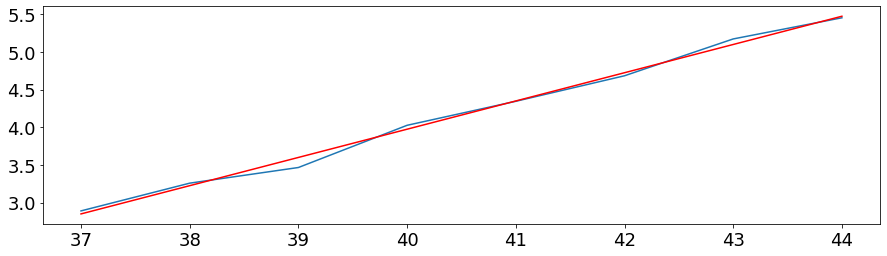

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

country = 'US'
df = lin_df[['date_count', country]].copy()
df = df[df.date_count >= 37]
#df = df[df.date_count <= 20]
print(df.shape)

x = df.date_count.values.reshape(-1, 1)
y = df[country].values.reshape(-1, 1)
y = np.log(y)
regressor = LinearRegression()
regressor.fit(x, y)
y_fit = regressor.predict(x)

print('Intercept:', regressor.intercept_)
print('Slope:', regressor.coef_)

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()

In [22]:
x_fut = x.copy()
x_fut -= x.min()
x_fut += x.max()
y_fut = regressor.predict(x_fut)
print(y_fut)
y_fut = np.exp(y_fut)
mat = np.c_[x_fut, y_fut].astype(int)
print(mat)

[[5.47147037]
 [5.84592565]
 [6.22038094]
 [6.59483622]
 [6.9692915 ]
 [7.34374679]
 [7.71820207]
 [8.09265736]]
[[  44  237]
 [  45  345]
 [  46  502]
 [  47  731]
 [  48 1063]
 [  49 1546]
 [  50 2248]
 [  51 3270]]
